## Code to reproduce Figure 9

## Import packages

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import pickle
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import ScalarFormatter
import palettable
import cftime

In [43]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'

plt.rc('font', size=16)          # controls default text sizes          
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

## Functions

In [51]:
def calc_oct_mean(df):
    
    df['time']=timestamp
    temp = df.ozone_hole_area[:]/1e6 # from m2 to km2
    october_df = temp.where(temp["time.month"] == 10, drop=True)
    da_oct_mean = october_df.groupby('time.year').mean('time')
    
    return da_oct_mean

def calc_saod(df):
    aitken_soluble = df.m01s02i251[2,:,:,:]
    accum_soluble = df.m01s02i252[2,:,:,:]
    coarse_soluble = df.m01s02i253[2,:,:,:]    
    aitken_insoluble = df.m01s02i254[2,:,:,:]
    
    SAOD_sum = aitken_soluble + accum_soluble + coarse_soluble + aitken_insoluble
   
    weights = np.cos(np.deg2rad(SAOD_sum.latitude))
    weights.name = "weights"
    
    SAOD_sum_weighted = SAOD_sum.weighted(weights)

    SAOD_zonalmean = SAOD_sum_weighted.mean("longitude")

    return SAOD_zonalmean


def plot_eruptions(df, yloc, ax):
    # large eruptions
    selected_data = df
    ax.scatter(selected_data['Year'][selected_data['SO2'] >= 3], 
            np.full(len(selected_data['Year'][selected_data['SO2'] >= 3]), yloc), 
            color = 'black', marker='^', s = 2500)#, label = 'Large-magnitude eruptions \n(>= 3 Tg Mass of SO$_2$)')
  
    # small eruptions
    ax.scatter(selected_data['Year'][(selected_data['SO2'] >= 1) & (selected_data['SO2'] < 3)], 
                np.full(len(selected_data['Year'][(selected_data['SO2'] >= 1) & (selected_data['SO2'] < 3)]), yloc), 
                color = 'grey', marker='^', s = 1000)#, label = 'Small-magnitude eruptions \n(between 1 - 3 Tg Mass of SO$_2$)')
    
    ax.scatter(selected_data['Year'][(selected_data['SO2'] >= 0.1) & (selected_data['SO2'] < 1)], 
                np.full(len(selected_data['Year'][(selected_data['SO2'] >= 0.1) & (selected_data['SO2'] < 1)]), yloc), 
                color = 'lightgrey', marker='^', s = 300)#, label = 'Small-magnitude eruptions \n(between 0.1 - 1 Tg Mass of SO$_2$)')
    return ax

def plot_area_saod(data_mean, data_max, data_min, data_scenario, data_saod, scenario):
    
    daysince = np.arange(2015,2101,1)
    
    ax1.plot(daysince, data_mean, marker = 'o', color = 'navy', label = 'VOLC', lw = 2, ms=1)
    ax1.plot(daysince, dn_mean, marker = 'o', color = 'red', label = 'NOVOLC', lw = 2, ms=1)
    ax1.fill_between(daysince, data_mean, data_max, color = 'lightblue', alpha = 0.3)
    ax1.fill_between(daysince, data_mean, data_min, color = 'lightblue', alpha = 0.3)
    ax1.fill_between(daysince, dn_mean, dn_max_oct, color = 'pink', alpha = 0.1)
    ax1.fill_between(daysince, dn_mean, dn_min_oct, color = 'pink', alpha = 0.1)
    
    yloc = -5
    plot_eruptions(data_scenario, yloc, ax1)
    ax1.set_xticklabels([''])
    
    ax2.grid(color='grey', which = 'both', linestyle=':', linewidth=1, alpha = 0.2)
    
    year_axis = np.arange(2015,2100,10)
    
    color = mcolors.LogNorm(0.01, 1000)
    
    cmap = ListedColormap(palettable.cmocean.sequential.Matter_6.mpl_colors[1:])
    
    daysince = cftime.date2num(data_saod.time, 'days since 2015-01-01', '360_day')
    
    levels1 = np.linspace(0.01,0.5,100)
    sc2 = ax2.contourf(daysince, data_saod.latitude, data_saod.transpose(), levels1, 
                       cmap = 'Blues', extend = 'both', vmax = 0.5, vmin = 0.01)
    
    formatter = ScalarFormatter()
    cbar2 = plt.colorbar(sc2, ticks=[0.01,0.1,0.2,0.3,0.4,0.5], format=formatter, 
                         orientation = "horizontal", fraction = 0.3, pad = 0.3)
    
    cbar2.ax.tick_params(labelsize = 15)
    cbar2.outline.set_visible(True)
    cbar2.set_label('SAOD (550 nm)', fontsize = 15, labelpad = 2)
    
    ax2.set_xlabel('Year', fontsize = 15)
    ax2.set_ylabel('Latitude', fontsize = 15)
    ax2.set_ylim(-90, 90)
    ax2.xaxis.set_major_locator(mdates.YearLocator(10))
    ax2.set_xticklabels(year_axis)
    ax2.set_xlim(0,daysince.max())
    ax1.legend(fontsize = 14, loc = 'upper right', frameon=False)
    
    for ax in (ax1, ax2):
        ax.tick_params(axis='y', labelsize=15)
        ax.tick_params(axis='x', labelsize=15)
        ax1.set_ylabel('Area (million km$^2$)', fontsize=15)
        ax1.set_xlim(2015,2100)
        ax1.set_ylim(yloc,25)
        ax.grid(color='grey', which = 'both', linestyle='dotted', linewidth=1, alpha = 0.2)
    
    ax1.set_title(scenario, fontsize=16, loc = 'left')

    return

def calc_diff_year_return(df, dn):

    temp = df - dn
    
    ## change threshold here
    area_threshold = 1
    
    def get_last_year(df):
        try:
            return df.year[df > area_threshold][-1]
        except IndexError:
            return 0

    year1 = get_last_year(temp[0,:])
    year2 = get_last_year(temp[1,:])
    year3 = get_last_year(temp[2,:])

    last_year1 = year1 + 1 if year1 != 0 else 0
    year_return = last_year1
    last_year2 = year2 + 1 if year2 != 0 else 0
    year_return_max = last_year2
    last_year3 = year3 + 1 if year3 != 0 else 0
    year_return_min = last_year3

    year_mean = (last_year1.values+last_year2.values+last_year3.values)/3 if year1 != 0 else 0
    year_maximum = max(last_year1.values,last_year2.values,last_year3.values)if year1 != 0 else 0
    year_minimum = min(last_year1.values,last_year2.values,last_year3.values)if year1 != 0 else 0

    print(round(year_mean), '(',year_minimum,'-',year_maximum,')')
        
    return year_return, year_return_max, year_return_min

## Read files

In [53]:
ozone_thres = '220DU'
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/Ozone_daily/\
Ozone_processed/antarctic_ozone_hole/ozone_hole_'+ozone_thres+'/')

timestamp = xr.open_dataset('/gws/nopw/j04/vplume/mchim/netcdf_files/Ozone_daily/\
Ozone_processed/ozone_deficit/antarctic_220/cj313_daily_ozone_deficit_220DU.nc').time

novolc = ['cj313','cj314','cj315']
volc50_1 = ['cj348','cj349','cj350']
volc50_2 = ['ck531','ck532','ck533']
volc50_1s = ['cj638','cj639','cj640']
volc50_2s = ['ck534','ck535','ck536']
volc98 = ['cn754','cn755','cn756']
volc25 = ['co565','co566','co567']

ssp370_run = {'novolc': novolc,
              'volc50_1': volc50_1,
              'volc50_2': volc50_2,
              'volc50_1s': volc50_1s,
              'volc50_2s': volc50_2s,
              'volc98': volc98,
              'volc25': volc25}

for idx in ssp370_run:
    
    suite_id = ssp370_run[idx]
    list_temp = []
    
    for i, id in enumerate(suite_id):

        filename = id+'_daily_ozone_area_'+ozone_thres+'.nc'
        df = xr.open_dataset(filename)
        temp = calc_oct_mean(df)
        list_temp.append(temp)

    df = xr.concat(list_temp, dim='ensemble')
       
    ssp370_run[idx] = df

In [36]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/SAOD_monthly/')

novolc = ['cj313','cj314','cj315']
volc50_1 = ['cj348','cj349','cj350']
volc50_2 = ['ck531','ck532','ck533']
volc98 = ['cn754','cn755','cn756']
volc25 = ['co565','co566','co567']

ssp370_saod = {'novolc': novolc,
              'volc50_1': volc50_1,
              'volc50_2': volc50_2,
              'volc98': volc98,
              'volc25': volc25}

for idx in ssp370_saod:
    
    suite_id = ssp370_saod[idx]
    list_temp = []
    
    for i, id in enumerate(suite_id):

        filename = f'u-{id}_monthly_SAOD.nc'
        df = xr.open_dataset(filename)
        temp = calc_saod(df)
        list_temp.append(temp)

    df = xr.concat(list_temp, dim='ensemble')
       
    ssp370_saod[idx] = df.mean(dim='ensemble')

In [7]:
path = '/home/users/mmc70/Notebooks/GRL_notebooks/GRL_data_repository/'

df_volc25 = pd.read_csv(path+'stochastic_volc2_5.csv')
df_volc50_1 = pd.read_csv(path+'stochastic_volc50_1.csv')
df_volc50_2 = pd.read_csv(path+'stochastic_volc50_2.csv')
df_volc98 = pd.read_csv(path+'stochastic_volc98.csv')

/tmp/ipykernel_10297/1703519207.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''])
/tmp/ipykernel_10297/1703519207.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_axis)


Text(2005, 27, 'a')

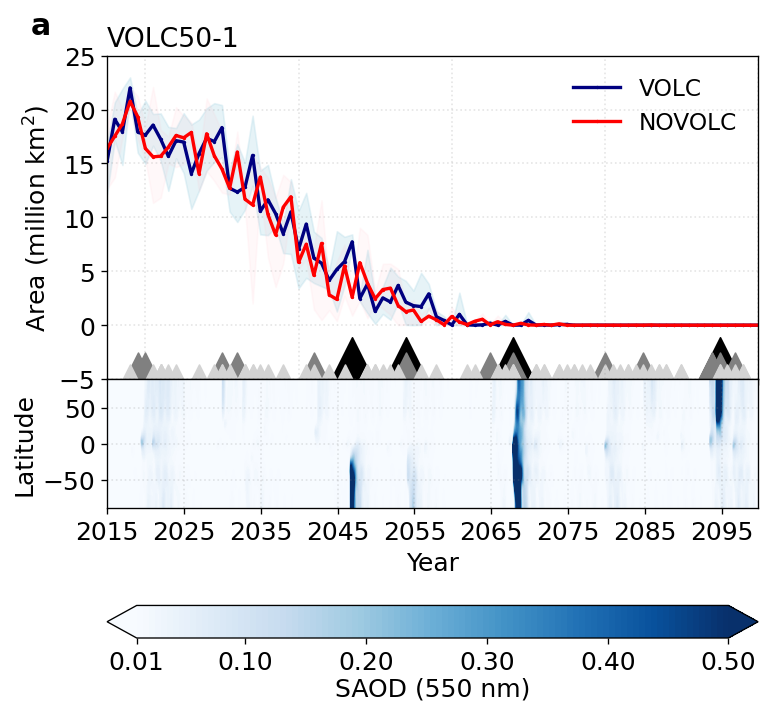

In [41]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(7,7),dpi=120, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)

plot_area_saod(ssp370_run['volc50_1'].mean(dim='ensemble'), 
               ssp370_run['volc50_1'].max(dim='ensemble'),
               ssp370_run['volc50_1'].min(dim='ensemble'), 
               df_volc50_1, ssp370_saod['volc50_1'], 'VOLC50-1')

ax1.text(2005, 27, 'a', weight = 'bold', fontsize = 18)

/tmp/ipykernel_10297/1703519207.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''])
/tmp/ipykernel_10297/1703519207.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_axis)


Text(2005, 27, 'b')

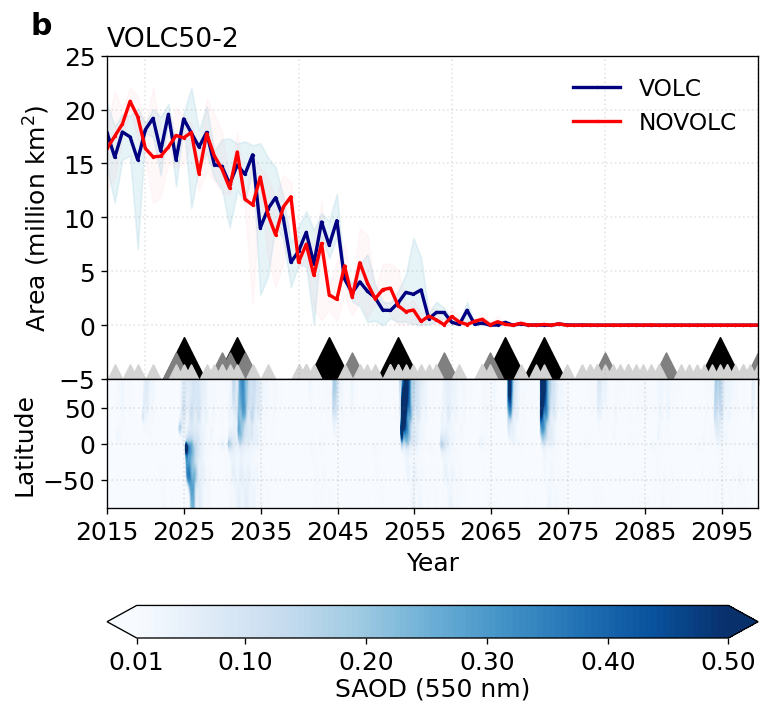

In [27]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(7,7),dpi=120, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)

plot_area_saod(ssp370_run['volc50_2'].mean(dim='ensemble'), 
               ssp370_run['volc50_2'].max(dim='ensemble'),
               ssp370_run['volc50_2'].min(dim='ensemble'), 
               df_volc50_2, db_saod, 'VOLC50-2')

ax1.text(2005, 27, 'b', weight = 'bold', fontsize = 18)

/tmp/ipykernel_10297/1703519207.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''])
/tmp/ipykernel_10297/1703519207.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_axis)


Text(2005, 27, 'c')

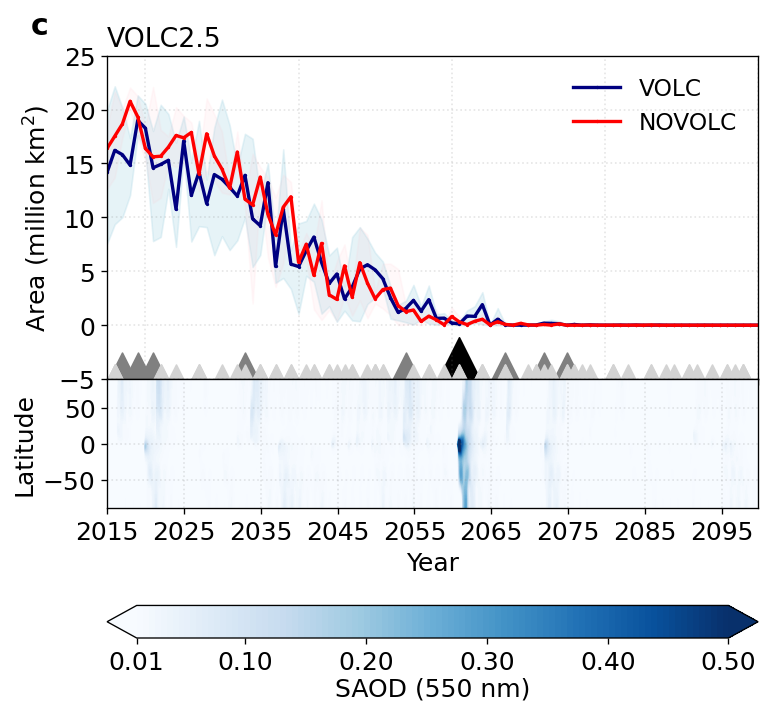

In [29]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(7,7),dpi=120, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)

plot_area_saod(ssp370_run['volc25'].mean(dim='ensemble'), 
               ssp370_run['volc25'].max(dim='ensemble'),
               ssp370_run['volc25'].min(dim='ensemble'), 
               df_volc25, de_saod, 'VOLC2.5')

ax1.text(2005, 27, 'c', weight = 'bold', fontsize = 18)

/tmp/ipykernel_10297/1703519207.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''])
/tmp/ipykernel_10297/1703519207.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_axis)


Text(2005, 27, 'd')

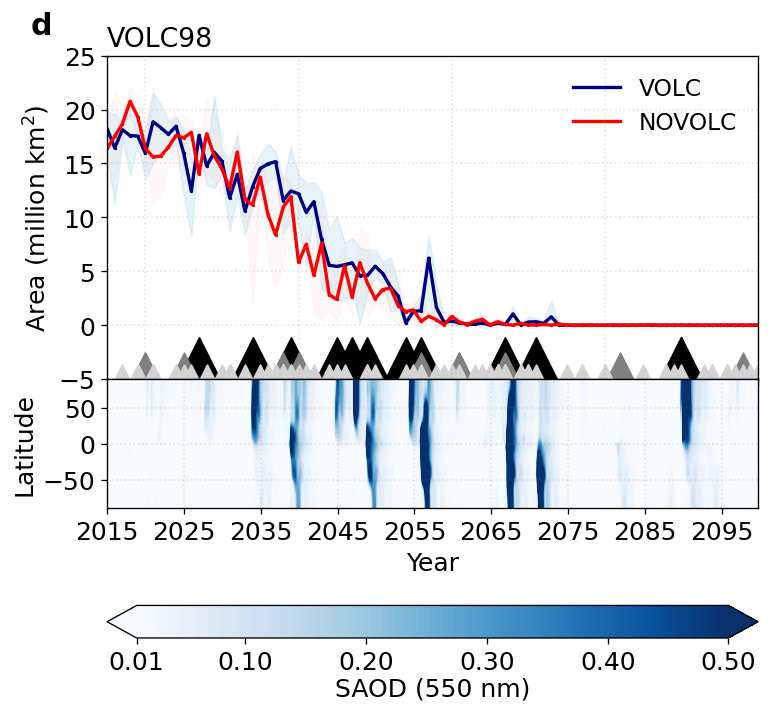

In [30]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(7,7),dpi=120, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(wspace=0, hspace=0)

plot_area_saod(ssp370_run['volc98'].mean(dim='ensemble'), 
               ssp370_run['volc98'].max(dim='ensemble'),
               ssp370_run['volc98'].min(dim='ensemble'), 
               df_volc98, df_saod, 'VOLC98')

ax1.text(2005, 27, 'd', weight = 'bold', fontsize = 18)

In [56]:
## SSP370
print('volc50-1')
a,b,c = calc_diff_year_return(ssp370_run['volc50_1'],ssp370_run['novolc'])

print('\nvolc50-2')
a,b,c = calc_diff_year_return(ssp370_run['volc50_2'],ssp370_run['novolc'])

print('\nvolc50-1s')
a,b,c = calc_diff_year_return(ssp370_run['volc50_1s'],ssp370_run['novolc'])

print('\nvolc50-2s')
a,b,c = calc_diff_year_return(ssp370_run['volc50_2s'],ssp370_run['novolc'])

print('\nvolc25')
a,b,c = calc_diff_year_return(ssp370_run['volc25'],ssp370_run['novolc'])

print('\nvolc98')
a,b,c = calc_diff_year_return(ssp370_run['volc98'],ssp370_run['novolc'])

volc50-1
2064 ( 2058 - 2071 )

volc50-2
2062 ( 2059 - 2063 )

volc50-1s
2058 ( 2057 - 2061 )

volc50-2s
2060 ( 2060 - 2061 )

volc25
2066 ( 2065 - 2067 )

volc98
2071 ( 2069 - 2074 )
